<center>



 
  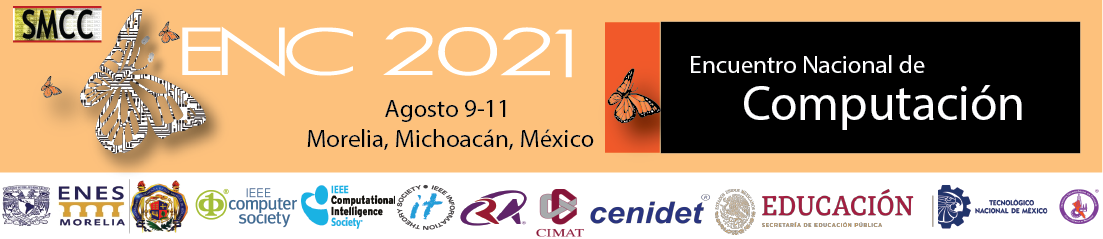

#Generando Arte Artificial con GAN's - ENC 2021
</center>



*   David Emmanuel Maqueda Bojorquez
*   María Guadalupe Quijano Escalera
*   Dr. Ivan Vladimir Meza Ruiz




## 1. Importación de módulos

Se importan los módulos necesarios para el funcionamiento del script

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import random
import torchvision
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

## 2. Conectar nuestro google drive

La plataforma colab puede acceder a nuestro google drive, en particular esto nos sirve para tener acceso al dataset de entrenamiento (recordar que la máquina virtual en la que se ejecuta colab deja de existir después de un tiempo de inactividad o máximo 8 horas). 

Para lograr la conexión, ejecutar la celda, y hacer click en el link generado automáticamente; confirmar con el sistema google la conexión hasta identificar el código de acceso que se pegará en la caja de texto de la misma celda. Después de unos segundos aparecerá el mensaje que google drive se ha 'montado' en ua ruta "/content/gdrive"

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

## 3. Descomprimir el archivo .zip

Es necesario identificar la ruta de acceso para el archivo a descomprimir, así como el fichero donde se desea descomprimir, en caso de ya tener el archivo descomprimido no es necesario ejecutar esta celda


In [ ]:
!unzip '/content/gdrive/MyDrive/data_taller/celeba.zip' -d '/content/gdrive/MyDrive/data_taller/celeba'

## 3. Fijar Hiperparámetros

Los hiperparámetros son valores que se establecen antes del entrenamiento y no se modifican durante el mismo, son identificadores cuyo valor se utiliza para controlar el proceso de aprendizaje, se utilizan para parametrizar el propio proceso de instanciación del modelo. Puedes pensar en ellos como las herramientas utilizadas para describir la configuración del modelo, de esta forma son valores los cuales permiten fijar la forma de entrenamiento y como se llevará a cabo entre otras cosas, en esta celda se definen variables las cuales fungiran como hiperparámetros durante el resto del script


In [ ]:
#HIPERPARÁMETROS
workers = 2

# Tamaño del batch durante el entrenamiento
batch_size = 128

# Tamaño espacial de las imágenes de entrenamiento. Todas las imágenes cambiarán de tamaño a este
#   tamaño usando una transformación
image_size = 64

# Número de canales en las imágenes de entrenamiento. Para imágenes en color, esto es 3
nc = 3

# Tamaño del vector latente z (es decir, tamaño de la entrada del generador)
nz = 100

# Tamaño de los feature maps en el generador
ngf = 64

# Tamaño de los feature maps en el discriminador 
ndf = 64

# Número de épocas de entrenamiento
num_epochs = 1000

# Learning rate para optimizadores
lr = 0.0002

# Hiperparámetro Beta1 para el optimizador ADAM
beta1 = 0.5

# Número de GPU's disponibles, 0 si se usa CPU
ngpu = 1

##4. Usar el dataset

Esta celda nos permite el uso del dataset; una vez descomprimida la carpeta se obtiene su ruta y posteriormente se instancia en ImageFolder, ahí transformamos y normalizamos el dataset para poder ser utilizado.

Operar con grandes conjuntos de datos requiere cargarlos en la memoria de una vez, los programas tienden a ejecutarse lentamente debido a que se cargan conjuntos de datos pesados ​​una vez. PyTorch ofrece una solución para paralelizar el proceso de carga de datos con procesamiento por lotes automático mediante el uso de DataLoader. Se ha utilizado Dataloader para paralelizar la carga de datos, ya que esto aumenta la velocidad y ahorra memoria.

DataLoader reside en el paquete [torch.utils.data.](https://pytorch.org/docs/stable/data.html) Tiene varios parámetros entre los cuales el único argumento obligatorio que se debe pasar es el conjunto de datos que se debe cargar, y el resto son argumentos opcionales.



In [ ]:
data_directory = '/content/gdrive/MyDrive/data_taller/celeba'
dataset = dset.ImageFolder(root=data_directory,
                           transform=transforms.Compose([
                            transforms.Resize(image_size),
                            transforms.CenterCrop(image_size),
                            transforms.ToTensor(),
                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))


dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                        shuffle=True, num_workers=workers)
#dataloader = torchvision.datasets.CelebA(root: str, split: str = 'train', target_type: Union[List[str], str] = 'attr'
 #                   , transform: Optional[Callable] = None, target_transform: Optional[Callable] = None, download: bool = False)

device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

## 5. Muestreo de imagenes de entrenamiento

Esta celda selecciona una muestra del batch del dataset para tener una pre-visualización de las imágenes con las cuales se entrenará el modelo

In [ ]:
#Muestreo de imagenes de entrenamiento
real_batch = next(iter(dataloader))
plt.figure(figsize=(15,15))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[2:32], padding=2, normalize=True).cpu(),(1,2,0)))

##6 Inicialización de pesos

Los pesos del modelo se inicializarán aleatoriamente a partir de una distribución normal con media = 0 y desviación estándar = 0,02. La función weights_init toma un modelo inicializado como entrada y reinicializa todas las capas de normalización convolucional, convolucional-transpuesta y por lotes para cumplir con este criterio.

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
        

##7. Definición del Generador

Una red generadora por sí sola crearía solo ruido aleatorio, el concepto es que la red discriminadora hace de guía sobre cuáles imágenes crear y ayuda a la red generativa a aprender los aspectos que comprenden una imagen real.

La entrada al generador es ruido aleatorio creado a partir de los datos de entrenamiento. Los datos de entrenamiento pueden ser una imagen. El generator intenta imitar la imagen de entrada lo más cerca posible de la imagen real de los datos de entrenamiento. El objetivo del generator es engañar al discriminador.

Este generador esta compuesto de 4 capas convolucionales traspuestas 2D seguidas de una normalización por lotes y una función de activación ReLU, su última capa es tambien una convolucional traspuesta 2D con TanH como función de activación.

El módulo [ConvTranspose2d](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html) puede verse como el gradiente de Conv2d con respecto a su entrada. También se conoce como convolución de pasos fraccionados o deconvolución (aunque no es una operación de deconvolución real).

In [ ]:
# Código del Generador

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

##8. Creación del Generador 

Esta celda crea el generador con el hardware que tengamos asignado y posteriormente inicializa los pesos de la red neuronal con la función 'weights_init'

In [ ]:
# Creación del generador
netG = Generator(ngpu).to(device)

# Ultizar multiples GPU's si es necesario
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

#Aplicar la inicialización de pesos con la función 'weights_init'
netG.apply(weights_init)

#Mostrar el modelo
print(netG)

## 8. Definición del Discriminador

El discriminador, es una red de clasificación binaria que toma una imagen como entrada y genera una probabilidad escalar de que la imagen de entrada sea real (en lugar de falsa). Este generado toma una imagen de entrada de 3x64x64, la procesa a través de una serie de 4 capas Conv2d seguidas de BatchNorm2d y LeakyReLU y una última capa Conv2d seguida de una función de activación sigmoide. Esta arquitectura genera la probabilidad final a través de una función de activación Sigmoid.

El objetivo del discriminador es identificar qué entrada es real y cuál es falsa



In [ ]:
#Código del Generador

class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

##9. Creación del Discriminador

Esta celda crea el discriminador con el hardware que tengamos asignado y posteriormente inicializa los pesos de la red neuronal con la función 'weights_init'

In [ ]:
#Creación del discriminador
netD = Discriminator(ngpu).to(device)

# Ultizar multiples GPU's si es necesario
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
    
#Aplicar la inicialización de pesos con la función 'weights_init'
netD.apply(weights_init)

#Mostrar el modelo
print(netD)

## 10. Inicializaión de función de pérdida, tensor de vectores latentes, etiquetas y configuración del optimizador ADAM

Se inicializa BCE Loss (Binary Cross Entropy Loss).
La elección de una función de pérdida depende completamente del conjunto de datos, el problema que está tratando de resolver y la variante específica de ese problema. Para problemas de clasificación binaria, la función de pérdida más adecuada se llama BCE. Compara la predicción, que sea un número entre 0 y 1, con el objetivo real, que es 0 o 1. 

Dado a esto tenemos que clasificar las imagenes entre 0 (etiqueta de imagen falsa) y 1 (etiqueta de imagen verdadera).

Por otra parte para el método de optimización usaremos ADAM el cual se inicializa tanto para el Discriminador como el Generador con sus respectivos hiperparametros

In [ ]:
# Inicializar la función BCELoss
criterion = nn.BCELoss()

#Se crea el tensor de vectores latentes que usaremos para visualizar la progresión del generador
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Etiquetas para reales y falsas durante el entrenamiento
real_label = 1.
fake_label = 0.

# Configuración de ADAM para discriminador y generador
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

##11. Bucle de entrenamiento

Entrenar una red neuronal consiste en ajustar cada uno de los pesos de las entradas de todas las neuronas que forman parte de la red neuronal, para que las respuestas de la capa de salida se ajusten lo más posible a los datos que conocemos (hablando de aprendizaje supervisado).
<center>

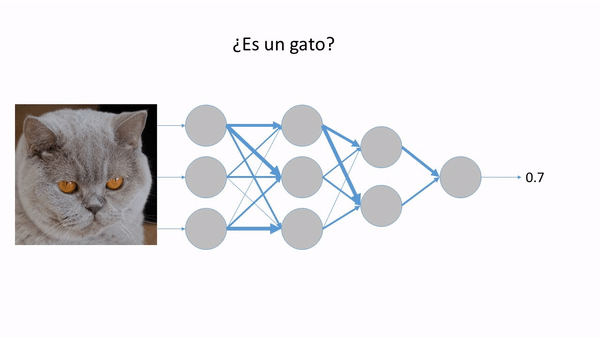
</center>

El problema de aprendizaje en las redes neuronales se formula en términos de la minimización de la función de error (o pérdida) asociada, normalmente, esta función evalúa cómo se ajusta la salida de la red neuronal al conjunto de datos de que disponemos. Por supuesto, el valor de la función de error depende por completo de los parámetros de la red neuronal. De esta forma como puede entenderse el proceso de entrenamiento es iterativo, un proceso de actualización constante de pesos al transcurrir las épocas. El número de épocas es un hiperparámetro que define el número de veces que el algoritmo de aprendizaje funcionará en todo el conjunto de datos de entrenamiento. Una época significa que cada muestra en el conjunto de datos de entrenamiento ha tenido la oportunidad de actualizar los parámetros internos del modelo. Una época se compone de uno o más lotes o batches.

De esta forma puede verse al entrenamiento como un proceso iterativo sobre las épocas y que funciona sobre un batch de entrenamiento donde las neuronas inicalizadas reciben la información del batch, generan una salida con un cierto error el cual se retropropaga ajustando los valores de los pesos mediane el optimizador y generando una reducción del error en cada iteración.


In [ ]:
# Loop de Entrenamiento
# Listas para el seguimiento del proceso
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Inicio de entrenamiento...")
# Por cada epoca
for epoch in range(num_epochs):
    # Por cada batch en el dataloaer
    for i, data in enumerate(dataloader, 0):

        ## Entrenamiento con todo el batch de imagenes reales
        netD.zero_grad()
        # Formateo del batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass del batch a través del Discriminador
        output = netD(real_cpu).view(-1)
        # Calculo de la pérdida en todo el batch
        errD_real = criterion(output, label)
        # Calculo de gradientes del Discriminador en backward
        errD_real.backward()
        D_x = output.mean().item()

        ##Entrenamiento con todo el batch de imagenes falsas

        # Generación del batch de vectores latentes
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generación del batch de imagenes falsas con el Generador
        fake = netG(noise)
        label.fill_(fake_label)
        # Clasificar el batch de imagenes falsas con el Discriminador
        output = netD(fake.detach()).view(-1)
        # Calculo de la perdida del Discrimador
        errD_fake = criterion(output, label)
        # calculo de gradientes
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Agrega los gradientes del batch de imagenes reales y de imagenes falsas
        errD = errD_real + errD_fake
        # Actualización del Discriminador
        optimizerD.step()

        netG.zero_grad()
        label.fill_(real_label)  # Las etiquetas falsas son reales para el costo del generador
        # Como acabamos de actualizar el Discriminador realice otra pasada hacia
        # adelante del lote totalmente falso a través del Discriminador
        output = netD(fake).view(-1)
        # Calcule la pérdida del Generador en función de esta salida
        errG = criterion(output, label)
        # Calculo de gradientes para del Generador
        errG.backward()
        D_G_z2 = output.mean().item()
        # Actualización del Generador
        optimizerG.step()
        
        # Salidas de estadisticas de entrenamiento
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        # Guarda las pérdidas del Generador y del Disriminador
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        # Compruebe cómo le está yendo al generador guardando la salida de G en Fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1

## 12. Visualización de la pérdida durante el entrenamiento

Esta celda muestra una gráfica de como evolucionó la pérdida al transcurrir las iteraciones en el entrenamiento, el objetivo principal en un modelo de aprendizaje es reducir (minimizar) el valor de la función de pérdida con respecto a los parámetros del modelo cambiando los valores del vector de peso a través de diferentes métodos de optimización, como la retropropagación en las redes neuronales.

El valor de pérdida implica qué tan bien o mal se comporta cierto modelo después de cada iteración de optimización. Idealmente, uno esperaría la reducción de la pérdida después de cada o varias iteraciones.

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Perdida del Generador y el Discriminador durante el entrenamiento")
plt.plot(G_losses,label="Generador")
plt.plot(D_losses,label="Discriminador")
plt.xlabel("Iteraciones")
plt.ylabel("Perdida")
plt.legend()
plt.show()

## 13. Captura de la salida

Esta celda muestra como una animación de la evolución de la salida de la red neuronal, como puede notarse al inicio del entrenamiento la red da como salida ruido aleatorio el cuál se va modificando y mostrando una imagen mas parecida a las de entrenamiento, esto concuerda con la teoría.

La calidad de las imágenes entre otras cosas dependerá de la cantidad de épocas que se entrene el modelo.

In [ ]:
#%%capturar
fig = plt.figure(figsize=(20,20))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

## Muestra de Imágenes Reales vs Imágenes Falsas

Esta ultima celda genera un plot de un batch real y un batch de imagenes falsas, esto para dar una visualización de las diferencias y/o similitudes entre ambos conjuntos de imágenes.


In [ ]:
# Toma un batch de imágenes reales del Dataloader
real_batch = next(iter(dataloader))

# Muestra las imagenes reales
plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Imágenes Reales")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Muestra las imagenes fake de la ultima epoca
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Imágenes Falsas")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

<center> 

#¿Que sigue? 
  
</center>

Con esto tienes las herramientas básicas escenciales para entender el funcionamiento de la red neuronal GAN para la generación de arte artificial puedes experimentar y hacer tus propias pruebas:


*   Modificando la arquitectura de la red
*   Probando otros datasets
* Entrenando por más tiempo el modelo
* Investigando e implementando otras metodologías

Suerte codeando





